# Tropical Cyclone Damage Assesment

<b>Challenge Aim: </b><p align="justify"> <p>

Participants will have to build a machine learning model, which can identify and detect the following objects in a satellite image of a cyclone impacted area: 
Undamaged Residential Building
Damaged Residential Building
Undamaged Commercial Building
Damaged Commercial Building


 In this notebook, we used both the pre and post event images from the Maxar GeoEye-1, and trained a object detection model using <a href = https://docs.ultralytics.com/>YOLOv8.</a> 
    


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

Run the below cell to install the packages. Note that this cell needs to be run only once. 

This project requires a significantly strong hardwared infras to run and train the model due to its huge amount of data. Please consider any cloud providers' VM if your local computer does not satisfy the requirements.

In [ ]:
### Run this cell only once.
%pip install ultralytics
!pip install opencv-python-headless
!pip install labelme2yolo

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
#from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import os
import shutil
import zipfile

%matplotlib inline

## Importing the Data

<div align="justify">Before building the model, we need to load both Pre-Event and Post Event GeoTiFF Images. This data is from a certain region in San Juan, Puerto Rico for the year 2017. The variables <b><i>pre_event_image</b></i> and <b><i>post_event_image</b></i> will have the path to both of these images. Consider that the images are considerably large and might require some time to load. The image named Pre_Event_San_Juan.tif is pre event image and is sized at 969 MB, while the image named as Post_Event_San_Juan.tif is post event image and sized at 1.2 GB.</div><br>

In [3]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif -O Pre_Event_San_Juan.tif

--2024-03-17 21:38:14--  https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1016993213 (970M) [application/octet-stream]
Saving to: ‘Pre_Event_San_Juan.tif’

Pre_Event_San_Juan. 100%[===================>] 969.88M   187MB/s    in 5.2s    

2024-03-17 21:38:28 (186 MB/s) - ‘Pre_Event_San_Juan.tif’ saved [1016993213/1016993213]



In [4]:
!wget https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif -O Post_Event_San_Juan.tif

--2024-03-17 21:38:30--  https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310494499 (1.2G) [application/octet-stream]
Saving to: ‘Post_Event_San_Juan.tif’

Post_Event_San_Juan 100%[===================>]   1.22G   164MB/s    in 7.0s    

2024-03-17 21:38:48 (177 MB/s) - ‘Post_Event_San_Juan.tif’ saved [1310494499/1310494499]



In [5]:
pre_event_image = './Pre_Event_San_Juan.tif'
post_event_image ='./Post_Event_San_Juan.tif'

#### Maxar GeoEye-1 Panchromatic Images

<div align = "justify">Maxar’s visual panchromatic band is a unique high-resolution product that applies RGB (red, green, blue) spectral information to a grey-scale panchromatic image at 30-cm resolution. No cloud masking has been provided with the dataset, so users should be cautious with the data as there are clouds in each of the images. A careful review of the RGB bands (see below) shows the clouds as saturated (dark) regions in each color band. You will find that the pre-storm image has far more clouds (mostly lower left) than the post-storm image (mostly upper portion).</div><br>

<div align = "justify">If you face kernel crash issue, while visualizing the images on notebook, you can visualize the images on <a href = "https://qgis.org/en/site/"><b>QGIS</b></a>, which is a free and open source Geographic Information System.</div>

## Visualising GeoTiFF Images

In [5]:
# Open the geotiff file
def load_and_visualize(image_path):
    with rasterio.open(image_path) as src:
        # read the red, green and blue bands
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
    # Plot the bands
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    ax1.imshow(red,cmap='Reds')
    ax1.set_title('Red Band')
    ax2.imshow(green, cmap='Greens')
    ax2.set_title('Green Band')
    ax3.imshow(blue, cmap='Blues')
    ax3.set_title('Blue Band')
plt.show()

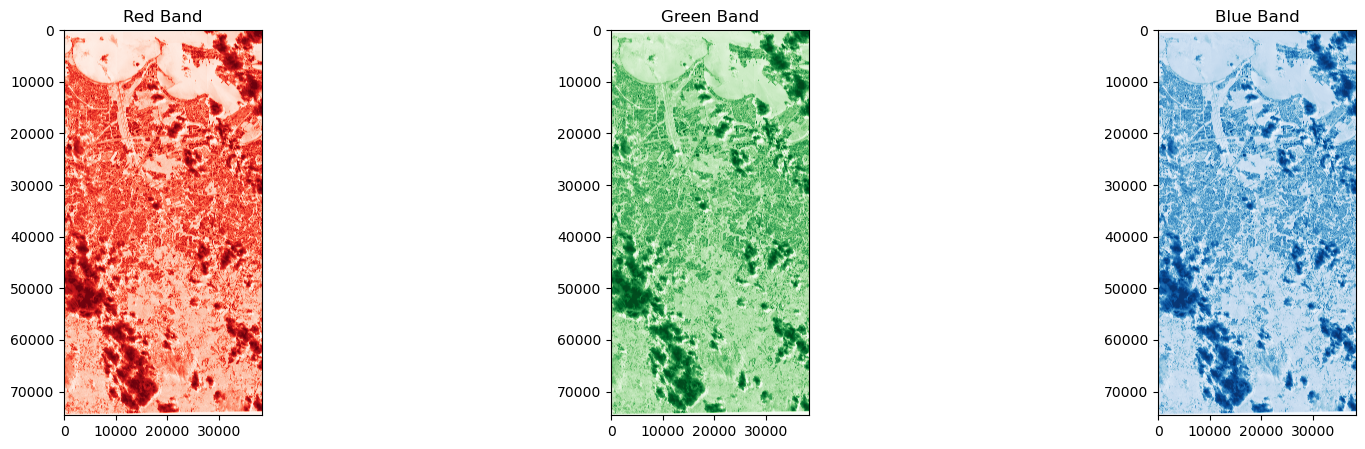

In [7]:
load_and_visualize(pre_event_image)

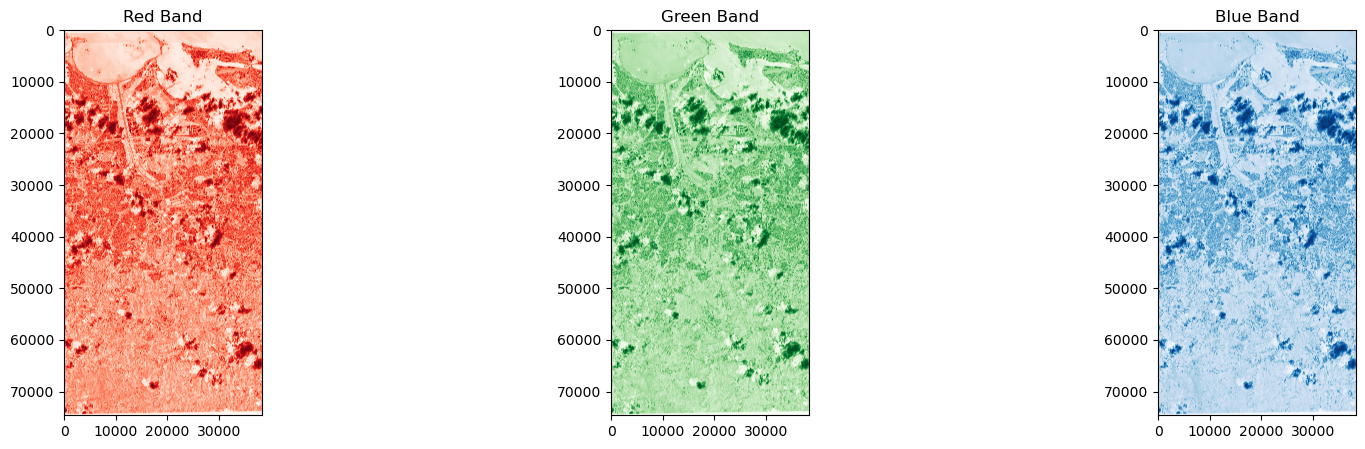

In [8]:
load_and_visualize(post_event_image)

## Data Pre Processing 

<div align="justify">Now that our data is loaded , we can we see that the area is quite huge, processing this is a very difficult task. Let's us proceed to create grids for the post-event images, this facilitates the processing of GeoTiFF image, and these grids will be saved in a specified directory. We create these grids using a function named <i><b>generate_tiles</b></i>. This function takes a .tiff image and the grid size, then transforms them into grids. In this specific case, we've made grids measuring 512x512.</div>

<p><b>Note:</b> This process may take few minutes to generate the grids.</p>

In [9]:
def generate_tiles(input_file, output_dir,grid_x,grid_y):
    ds = gdal.Open(input_file)

    # Get image size and number of bands
    width = ds.RasterXSize
    height = ds.RasterYSize
    num_bands = ds.RasterCount

    # Calculate number of tiles in each dimension
    num_tiles_x = (width // grid_x)
    num_tiles_y = (height // grid_y)

    print(f"Total number of tiles: {num_tiles_x * num_tiles_y}")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each tile and save as a separate TIFF image
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            x_offset = i *  grid_x
            y_offset = j *  grid_y

            tile_width = min(grid_x, width - x_offset)
            tile_height = min(grid_y, height - y_offset)

            tile = []
            for band in range(1, num_bands + 1):
                tile_data = ds.GetRasterBand(band).ReadAsArray(x_offset, y_offset, tile_width, tile_height)
                tile.append(tile_data)

            # Create output filename
            output_file = os.path.join(output_dir, f"tile_{i}_{j}.tif")
                
            # Create an output TIFF file with same CRS and band values range
            driver = gdal.GetDriverByName("GTiff")
            options = ['COMPRESS=DEFLATE', 'PREDICTOR=2', 'TILED=YES']
            out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, 
                       ds.GetRasterBand(1).DataType, options=options)
            # out_ds = driver.Create(output_file, tile_width, tile_height, num_bands, ds.GetRasterBand(1).DataType)

            # Set the geotransform
            geotransform = list(ds.GetGeoTransform())
            geotransform[0] = geotransform[0] + x_offset * geotransform[1]
            geotransform[3] = geotransform[3] + y_offset * geotransform[5]
            out_ds.SetGeoTransform(tuple(geotransform))

            # Set the projection
            out_ds.SetProjection(ds.GetProjection())

            # Write each band to the output file
            for band in range(1, num_bands + 1):
                out_band = out_ds.GetRasterBand(band)
                out_band.WriteArray(tile[band - 1])

            # Close the output file
            out_ds = None

    print("Tiles generation completed.")

In [10]:
input_file = "./Pre_Event_San_Juan.tif"
output_dir = "./Pre_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y)

Total number of tiles: 10730
Tiles generation completed.


In [ ]:
input_file = "./Post_Event_San_Juan.tif"
output_dir = "./Post_Event_Grids_In_TIFF"
grid_x = 512
grid_y = 512
generate_tiles(input_file, output_dir,grid_x,grid_y)

## Annotating the Images

<div align ="justify">Image annotation is the process of labelling images in a given dataset to train machine learning models. When the manual annotation is completed, labelled images are processed by a machine learning or deep learning model to replicate the annotations without human supervision. Image annotation sets the standards, which the model tries to copy, so any error in the labels is replicated too. Therefore, precise image annotation lays the foundation for neural networks to be trained, making annotation one of the most important tasks in computer vision.</div>

<div align="justify">Inorder to annotate images, we will convert them to .jpg images as majority of the annotaiton tools do not support .tif format. There are many open source annotation tools available. For this notebook, we will choose <a href = https://github.com/labelmeai/labelme/>LabelMe </a> as the annotation tool.

### Identifying Damaged and Undamged Infrastructure

<div align= "justify">Commercial structures often have larger rooftops and typically have parking areas. In contrast, residential buildings generally have more limited roof space. Buildings deemed as damaged often exhibit roof impairments, while those classified as undamaged have no visible damages. To further grasp the distinctions between damaged and undamaged buildings in both commercial and residential categories, please refer the <a href = "https://challenge.ey.com/api/v1/storage/admin-files/2513955341204317-65bb9169868dc8fadbfc9728-2024%20EY%20Open%20Science%20Data%20Challenge%20Participant%20Guidance.pdf">guidance document</a>. The document is designed to provide a more detailed and comprehensive understanding of these topics.</div>

<div align = "justify">In conclusion, it is safe to assert that the most challenging aspect of the entire model-building task is discerning between residential and commercial structures and the pinpointing of damaged building. </div>

### Converting Images to .png/.jpg images

<div align="justify">Since our annotation tool requires images to be in .jpg/.png format, let's proceed to convert the grids from .tiff format to .jpg format, this facilitates the processing of GeoTiFF image, and these grids in .jpg/.png will be saved in a specified directory. We convert these grids using a function named <i><b>convert_tiff_to_jpeg</b></i>.This function takes the folder with .tiff image as input and the output directory path, where these converted images need to be saved.</div>

In [3]:
def convert_tiff_to_jpeg(input_dir,output_dir):
    # check if output_dir exists, if not create it
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # check if file is an image (ends with .tif)
        if filename.endswith('.tif'):
            img = Image.open(os.path.join(input_dir, filename))
        
            # check if image is RGB mode, if not convert it
            if img.mode != 'RGB':
                img = img.convert('RGB')
        
            # create new filename, replace .tif with .jpg
            output_filename = os.path.splitext(filename)[0] + '.jpg'
        
            # save the image in JPEG format
            img.save(os.path.join(output_dir, output_filename), 'JPEG')
    print("Conversion from TIFF to JPEG completed.")

In [18]:
# specify directory
input_dir = "./Pre_Event_Grids_In_TIFF"
output_dir = "./Pre_Event_Grids_In_JPEG"
convert_tiff_to_jpeg(input_dir,output_dir)

input_dir = "./Post_Event_Grids_In_TIFF"
output_dir = "./Post_Event_Grids_In_JPEG"
convert_tiff_to_jpeg(input_dir,output_dir)

Conversion from TIFF to JPEG completed.


### Renaming the Files

<div align = "justify">For easier and more efficient data accessibility, it's necessary to rename the files in the directory. We'll use the function <b><i>rename_files</b></i> to accomplish this task of altering the file names in the given path.</div>

**Note**: You can change prefix to "Pre_Event_" if you want to change Pre-Event pictures

In [19]:
def rename_files(directory_path):
# Define the directory path where your files are located
    directory_path = directory_path
    
    # Get a list of all files in the directory
    files = os.listdir(directory_path)
     
    # Define a prefix for the new file names 
    # Change the prefix as per requirement
    prefix = "Post_Event_"
    
    # Start the numbering from 1
    number = 0
    
    # Loop through each file in the directory
    for filename in files:
        # Check if the item is a file (not a directory)
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Get the file extension
            file_extension = os.path.splitext(filename)[1]
    
            # Create the new file name with leading zeros
            new_filename = f"{prefix}{number:03}{file_extension}"
    
            # Construct the full path to the original and new files
            old_filepath = os.path.join(directory_path, filename)
            new_filepath = os.path.join(directory_path, new_filename)
    
            # Rename the file
            os.rename(old_filepath, new_filepath)
    
            # Increment the number for the next file
            number += 1
    
    print("Files renamed successfully.")

In [20]:
rename_files(output_dir)

Files renamed successfully.


#### Naming convention of class label

<div align="justify"> Please ensure that you follow the following naming convention for the different objects, while labelling. If a different naming convention is followed, it might lead to error during submission on platform. </div>

<table>
  <tr>
    <th>Object</th>
    <th>Naming Convention</th>
  </tr>
  <tr>
    <td>Undamaged Residential Building</td>
    <td>undamagedresidentialbuilding</td>
  </tr>
  <tr>
    <td>Damaged Residential Building</td>
    <td>damagedresidentialbuilding</td>
  </tr>
   <tr>
    <td>Undamaged Commercial Building</td>
    <td>undamagedcommercialbuilding</td>
  </tr>
     <tr>
    <td>Damaged Commercial Building</td>
    <td>damagedcommercialbuilding</td>
  </tr>
</table>


<div align = "justify">After the annotation process, participants can move onto the task of building their models. YOLOv8, however, requires annotations to be in a distinct format. Therefore, the next step is to convert these annotations into the YOLOv8-required format. There are numerous utility scripts/packages designed to facilitate the conversion from .json to .txt files, which YOLOv8 requires. In this case, we have utilized the labelme2yolo package to transform the .json file into .txt format and also to generate the configuration file (dataset.yaml)</div>

## Preparing the File Structure as required by YOLO 
<div align ="justify">The participants are required to construct the file structure as indicated below and adjust the dataset.yaml settings according to the file path provided.</div>

### File Structure
<div align="justify">YOLOv8, being a Deep Learning model for object detection, necessitates a specific directory framework for running effectively. The fundamental structure has a parent folder titled 'datasets', which further contains two subfolders: 'train', and 'val'.</div><br>

<div align="justify">The 'datasets' folder: As the name indicates, this folder houses the complete data that YOLOv8 will be working on. It is pivotal as the model gains insight, verifies accuracy, and enhances its effectiveness using the data stored here.</div><br>

<div align="justify">The 'train' subfolder: This is a subset of the datasets folder and houses a collection of both image files (.jpg format) and their corresponding annotation files (.txt format). The training data is used by the model to learn and create a mathematical function that can predict the output.</div><br>

<div align="justify">The 'val' subfolder: Similarly, this contains the test images and their corresponding annotations. The test data is not learned by the model. Instead, it's used to evaluate the performance of the model's learning.</div><br>

<div align="justify">The 'dataset.yaml' file: This is a vital document that encompasses critical details concerning the dataset and the manners of their use. It contains paths for training, testing, and their respective numbers of images, the total count of classes, and class labels. This is generated in the previous section - <b>YOLO Annotations Format and Train Test Split</b></div><br>

The files need to be organised in the following manner:
<ul>
    <li> dataset.yaml </li>
    <li>datasets</li>
<ul>
    <li> train </li>
    <ul>
        <li>image1.jpg</li>
        <li>image1.txt</li>
        <li>image2.jpg</li>
        <li>image2.txt</li>
        <li>image3.jpg</li>
        <li>image3.txt</li>
    </ul>
    <li> val</li>
    <ul>
        <li>image4.jpg</li>
        <li>image4.txt</li>
        <li>image5.jpg</li>
        <li>image5.txt</li>
        <li>image6.jpg</li>
        <li>image6.txt</li>
    </ul>
 
</ul>
    

   

### Data Source Directory
We have labeled around 2,000 post event pictures using LabelMe and randomly splitted it into training and vallidation set. The train directory, val directiory and dataset.yaml file is stored it folder name Trained_Data. Among 2,000 pictures, we use 80% for training and 20% for testing

## Model Building
<div align="justify">

Once the file structure is set up, we can proceed to the exercise of building the model. This process is iterative in nature, as participants have to keep experimenting and tweaking our model’s settings to improve its performance. Throughout this point, we continually assess the performance of our model using metric like mean average precission (mAP).</div>

<div align="justify">Post-training, the model needs to be validated using a different dataset to further confirm that it works accurately when exposed to unseen data. Lastly, our model should also ensure it is not overfit or underfit. An overfit model implies it is too complex and may not work well with new data, while an underfit model implies the model misses the relevant relations between features and target outputs.</div><br>

<div align="justify">Once we complete these steps, we will have a working model that we can now use for various predictions and interpretations.</div><br>

**Note**: If you encounter errors while running, please make sure to check the dataset.yaml file inside the data folder and adjust the train and val sources based on the paths on your computer

### Model Training

<div align ="justify">Now that we have the data in a format appropriate for developing the model, we can begin training a model. In this demonstration notebook, we have used pre-trained object detection model from YOLOv8 developed by Ultralytics. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</div>

In [12]:
#Loading the model
model = YOLO('yolov8s.pt')
# Display model information (optional)
model.info()

YOLOv8s summary: 225 layers, 11166560 parameters, 0 gradients, 28.8 GFLOPs


(225, 11166560, 0, 28.816844800000002)

In [13]:
# Train the model on the dataset for 50 epochs
results = model.train(data='/home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_Data/YOLODataset/dataset.yaml', weight_decay = 0.0015, epochs=60, imgsz=512)

Ultralytics YOLOv8.1.25 🚀 Python-3.11.4 torch-2.2.1+cu121 CPU (Intel Xeon Platinum 8272CL 2.60GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/dataset.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_t

train: Scanning /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/labels/train.cache... 275 images, 17 backgrounds, 0 corrupt: 100%|██████████| 275/275 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/train/0909bc1de5c3a0def4aa63f1b2c8ef12.png: 3 duplicate labels removed
train: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/train/09dd11945abca364e129c5c81baf8b4a.png: 2 duplicate labels removed
train: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/train/3d42ad94113782f7324319e25be219ab.png: 1 duplicate labels removed
train: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/train/43fcbfea533ec22253534c9eb6dcecb0.png: 1 duplicate labels removed
train: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/train/461c99baf1b80afd6729768a148bae21.png: 3 duplicate labels removed
train: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLO


val: Scanning /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/labels/val.cache... 69 images, 7 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<?, ?it/s]

val: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/val/0ce483aa257a23221368ae8223a14b9b.png: 4 duplicate labels removed
val: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/val/324184f93bfd68e66d38909d8804c73d.png: 2 duplicate labels removed
val: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/val/56f8cbca4b3e90c4c681fd513aee342b.png: 3 duplicate labels removed
val: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/val/5be8a6cd03434a6302320c606cefdfb4.png: 2 duplicate labels removed
val: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/val/6b3b5b8975b6e23d2416d1f8693bdb3d.png: 1 duplicate labels removed
val: WARNING ⚠️ /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/Trained_DataV16/YOLODataset/images/val/b3d

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0015), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60         0G      1.675      2.921      1.511         82        512: 100%|██████████| 18/18 [01:48<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.76s/it]

                   all         69        671      0.234      0.338      0.227      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60         0G      1.428      1.809      1.288         78        512: 100%|██████████| 18/18 [01:50<00:00,  6.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.61s/it]

                   all         69        671      0.418      0.374      0.349      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60         0G      1.417      1.809      1.268         44        512: 100%|██████████| 18/18 [01:50<00:00,  6.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.52s/it]

                   all         69        671      0.398      0.428       0.37      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60         0G      1.418      1.599      1.249         63        512: 100%|██████████| 18/18 [01:48<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

                   all         69        671      0.215       0.58      0.282      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60         0G      1.424      1.659      1.301         28        512: 100%|██████████| 18/18 [01:48<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.45s/it]

                   all         69        671      0.242      0.473       0.27       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60         0G        1.4      1.654      1.304         21        512: 100%|██████████| 18/18 [01:46<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.38s/it]

                   all         69        671      0.243      0.616      0.353      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60         0G      1.378      1.551      1.264         43        512: 100%|██████████| 18/18 [01:50<00:00,  6.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

                   all         69        671      0.306      0.619      0.321      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60         0G      1.357       1.51      1.264        130        512: 100%|██████████| 18/18 [01:48<00:00,  6.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]

                   all         69        671      0.336      0.433      0.322      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60         0G      1.357      1.436      1.289         42        512: 100%|██████████| 18/18 [01:48<00:00,  6.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.53s/it]

                   all         69        671      0.433      0.399      0.357      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60         0G      1.343      1.452      1.276         67        512: 100%|██████████| 18/18 [01:47<00:00,  5.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.44s/it]

                   all         69        671      0.356      0.551      0.409       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60         0G      1.368      1.416      1.299         26        512: 100%|██████████| 18/18 [01:48<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]

                   all         69        671      0.404      0.541      0.453      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60         0G      1.323      1.418      1.282         48        512: 100%|██████████| 18/18 [01:47<00:00,  5.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.42s/it]

                   all         69        671      0.406      0.563      0.446      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60         0G        1.3      1.349      1.253         59        512: 100%|██████████| 18/18 [01:48<00:00,  6.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.45s/it]

                   all         69        671      0.369      0.461      0.405      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60         0G      1.301      1.357      1.268         43        512: 100%|██████████| 18/18 [01:48<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.31s/it]

                   all         69        671      0.459      0.473      0.434      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60         0G      1.285       1.33      1.262         20        512: 100%|██████████| 18/18 [01:50<00:00,  6.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.31s/it]

                   all         69        671      0.484      0.554      0.517      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60         0G      1.296      1.383      1.245         71        512: 100%|██████████| 18/18 [01:49<00:00,  6.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.38s/it]

                   all         69        671      0.538      0.615      0.573      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60         0G      1.283       1.27       1.24         31        512: 100%|██████████| 18/18 [01:49<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.38s/it]

                   all         69        671      0.477      0.555      0.517       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60         0G      1.255      1.174      1.216         35        512: 100%|██████████| 18/18 [01:49<00:00,  6.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.47s/it]

                   all         69        671      0.593       0.51      0.543      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60         0G      1.221      1.202      1.202         51        512: 100%|██████████| 18/18 [01:49<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]

                   all         69        671      0.461      0.556      0.491      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60         0G      1.276      1.215      1.254         10        512: 100%|██████████| 18/18 [01:49<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.45s/it]

                   all         69        671      0.506      0.606      0.507      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60         0G      1.263      1.223      1.221         78        512: 100%|██████████| 18/18 [01:50<00:00,  6.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.48s/it]

                   all         69        671      0.473      0.507      0.483      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60         0G      1.225      1.179      1.208         40        512: 100%|██████████| 18/18 [01:48<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.27s/it]

                   all         69        671       0.54      0.624      0.593      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60         0G      1.187       1.14      1.185         23        512: 100%|██████████| 18/18 [01:49<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.32s/it]

                   all         69        671      0.601      0.548      0.602      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60         0G      1.197       1.13      1.174         34        512: 100%|██████████| 18/18 [01:47<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.27s/it]

                   all         69        671      0.598      0.638      0.604      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60         0G      1.153      1.154      1.169         27        512: 100%|██████████| 18/18 [01:47<00:00,  6.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.42s/it]

                   all         69        671      0.638      0.602      0.632      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60         0G      1.178       1.08      1.178        114        512: 100%|██████████| 18/18 [01:49<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.35s/it]

                   all         69        671      0.634      0.634      0.652      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60         0G      1.208      1.056      1.179         25        512: 100%|██████████| 18/18 [01:50<00:00,  6.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.23s/it]

                   all         69        671      0.649      0.558      0.606      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60         0G      1.202      1.029      1.185         42        512: 100%|██████████| 18/18 [01:48<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

                   all         69        671      0.643      0.606      0.649      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60         0G      1.129     0.9968      1.166         44        512: 100%|██████████| 18/18 [01:49<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.34s/it]

                   all         69        671      0.596      0.618      0.646      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60         0G      1.137      1.009      1.141         72        512: 100%|██████████| 18/18 [01:49<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.51s/it]

                   all         69        671       0.62      0.542      0.591      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60         0G       1.13     0.9713      1.153         75        512: 100%|██████████| 18/18 [01:52<00:00,  6.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.37s/it]

                   all         69        671      0.621      0.641      0.638      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60         0G      1.127     0.9844      1.143         24        512: 100%|██████████| 18/18 [01:50<00:00,  6.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

                   all         69        671      0.556      0.631      0.615      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60         0G      1.097     0.9638      1.142         21        512: 100%|██████████| 18/18 [01:49<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.28s/it]

                   all         69        671      0.653      0.602      0.648      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60         0G      1.101     0.9439      1.136         14        512: 100%|██████████| 18/18 [01:51<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.32s/it]

                   all         69        671      0.589       0.61      0.602      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60         0G      1.105     0.9516       1.14         58        512: 100%|██████████| 18/18 [01:49<00:00,  6.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.33s/it]

                   all         69        671      0.644        0.6      0.644      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60         0G      1.081     0.9429      1.138         59        512: 100%|██████████| 18/18 [01:51<00:00,  6.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.30s/it]

                   all         69        671      0.577      0.673      0.655      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60         0G      1.062     0.9072      1.134         30        512: 100%|██████████| 18/18 [01:49<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.15s/it]

                   all         69        671      0.709       0.63       0.68      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60         0G      1.071     0.8627      1.121         44        512: 100%|██████████| 18/18 [01:49<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.22s/it]

                   all         69        671       0.73      0.596      0.662      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60         0G       1.07     0.8998      1.114         37        512: 100%|██████████| 18/18 [01:49<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]

                   all         69        671      0.537       0.65      0.606      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60         0G      1.067     0.8803      1.113        122        512: 100%|██████████| 18/18 [01:48<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.43s/it]

                   all         69        671      0.692      0.612      0.655      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60         0G      1.061     0.9056      1.114         22        512: 100%|██████████| 18/18 [01:51<00:00,  6.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.26s/it]

                   all         69        671      0.643      0.612      0.652      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60         0G      1.043      0.857      1.113         37        512: 100%|██████████| 18/18 [01:49<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.47s/it]

                   all         69        671      0.661       0.63      0.653      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60         0G      1.041     0.8299      1.111         58        512: 100%|██████████| 18/18 [01:47<00:00,  5.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.32s/it]

                   all         69        671      0.687      0.645      0.679      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60         0G      1.004     0.8034      1.093         15        512: 100%|██████████| 18/18 [01:48<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.42s/it]

                   all         69        671      0.663       0.64      0.681      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60         0G      1.009     0.8265        1.1          7        512: 100%|██████████| 18/18 [01:49<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

                   all         69        671      0.684      0.643      0.678      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60         0G      1.004     0.8117      1.097         38        512: 100%|██████████| 18/18 [01:50<00:00,  6.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.18s/it]

                   all         69        671      0.702       0.66      0.684      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60         0G     0.9951     0.7607      1.085         18        512: 100%|██████████| 18/18 [01:48<00:00,  6.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]

                   all         69        671      0.737      0.667        0.7      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60         0G     0.9749     0.7562      1.087         31        512: 100%|██████████| 18/18 [01:48<00:00,  6.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.31s/it]

                   all         69        671      0.695      0.635      0.677      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60         0G     0.9903     0.7823      1.076         10        512: 100%|██████████| 18/18 [01:49<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.14s/it]

                   all         69        671      0.683       0.62      0.674      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60         0G     0.9615     0.7398       1.06         53        512: 100%|██████████| 18/18 [01:49<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.32s/it]

                   all         69        671      0.693      0.663      0.692       0.47


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60         0G     0.9568     0.7267      1.065         40        512: 100%|██████████| 18/18 [01:43<00:00,  5.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.43s/it]

                   all         69        671      0.675       0.68      0.686       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60         0G     0.9413     0.6886       1.06         13        512: 100%|██████████| 18/18 [01:42<00:00,  5.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.29s/it]

                   all         69        671      0.671      0.681       0.68      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60         0G      0.887     0.6449       1.04         29        512: 100%|██████████| 18/18 [01:43<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.41s/it]

                   all         69        671      0.693      0.669      0.703       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60         0G     0.9132     0.6488      1.039         42        512: 100%|██████████| 18/18 [01:43<00:00,  5.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.37s/it]

                   all         69        671      0.679      0.688      0.696       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60         0G     0.9121      0.637      1.043         60        512: 100%|██████████| 18/18 [01:43<00:00,  5.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.40s/it]

                   all         69        671      0.701      0.672      0.706      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60         0G     0.8929     0.6261      1.041         20        512: 100%|██████████| 18/18 [01:43<00:00,  5.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.47s/it]

                   all         69        671      0.707       0.66      0.704      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60         0G     0.8568     0.5996      1.026         55        512: 100%|██████████| 18/18 [01:42<00:00,  5.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.42s/it]

                   all         69        671      0.688      0.664      0.698      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60         0G     0.8322     0.5824      1.009         13        512: 100%|██████████| 18/18 [01:42<00:00,  5.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.27s/it]

                   all         69        671      0.765      0.617      0.703      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60         0G     0.8467     0.6119      1.022          8        512: 100%|██████████| 18/18 [01:42<00:00,  5.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.33s/it]

                   all         69        671      0.721      0.645      0.706      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60         0G     0.8475     0.5739      1.013         54        512: 100%|██████████| 18/18 [01:40<00:00,  5.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.32s/it]

                   all         69        671      0.759      0.627      0.708      0.487



60 epochs completed in 1.982 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.25 🚀 Python-3.11.4 torch-2.2.1+cu121 CPU (Intel Xeon Platinum 8272CL 2.60GHz)
Model summary (fused): 168 layers, 11127132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:10<00:00,  3.37s/it]


                   all         69        671      0.715      0.646      0.706      0.491
damagedcommercialbuilding         69         28      0.809      0.714      0.781      0.635
undamagedcommercialbuilding         69        101      0.756      0.737       0.81      0.604
undamagedresidentialbuilding         69        434      0.782      0.781      0.811      0.504
damagedresidentialbuilding         69        108      0.515      0.352      0.424      0.223
Speed: 0.7ms preprocess, 114.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train


##### <b>Note: Participants, can find the model weights in runs\detect\ ....</b>

## Model Evaluation

<div align ="justify">Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the mean average precission report. We will then plot the image results to visualise the results. When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the in-sample and out-of-sample performance, we will see the results using the graph now.</div>

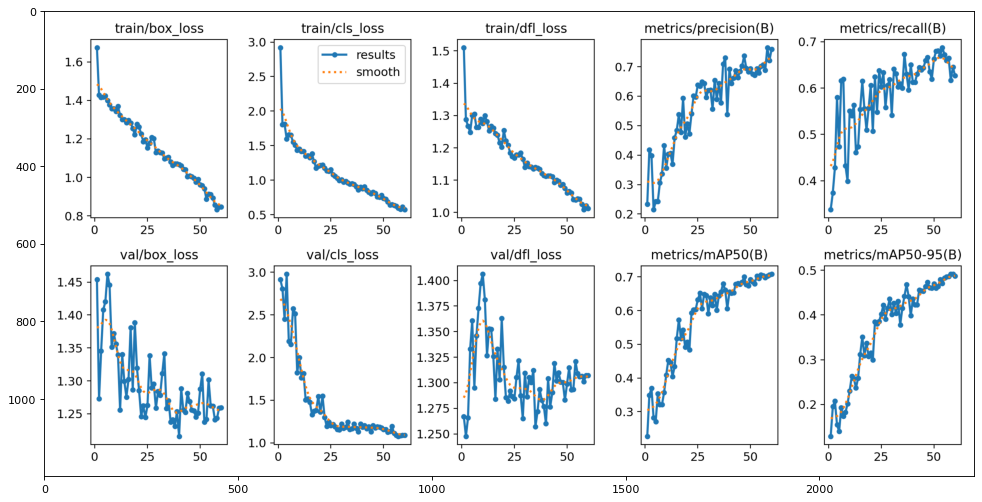

In [14]:
figure(figsize=(15, 10), dpi=80)
# reading the image 
results = img.imread('runs/detect/train/results.png')   
# displaying the image 
plt.imshow(results) 

<div align ="justify">From the above results we can see that we achieved an overall MAP-50 of 0.71 and the following MAP-50 on the various classes:
<ul>
    <li>Undamaged Commercial Building -0.81</li>
    <li>Undamaged Residential Building -0.81</li>
    <li>Damaged Residential Building - 0.42</li>
    <li>Damaged Commercial Building -0.78</li>
</ul>
</div>

Let us now look at the confusion matrix, to better analyse the results:

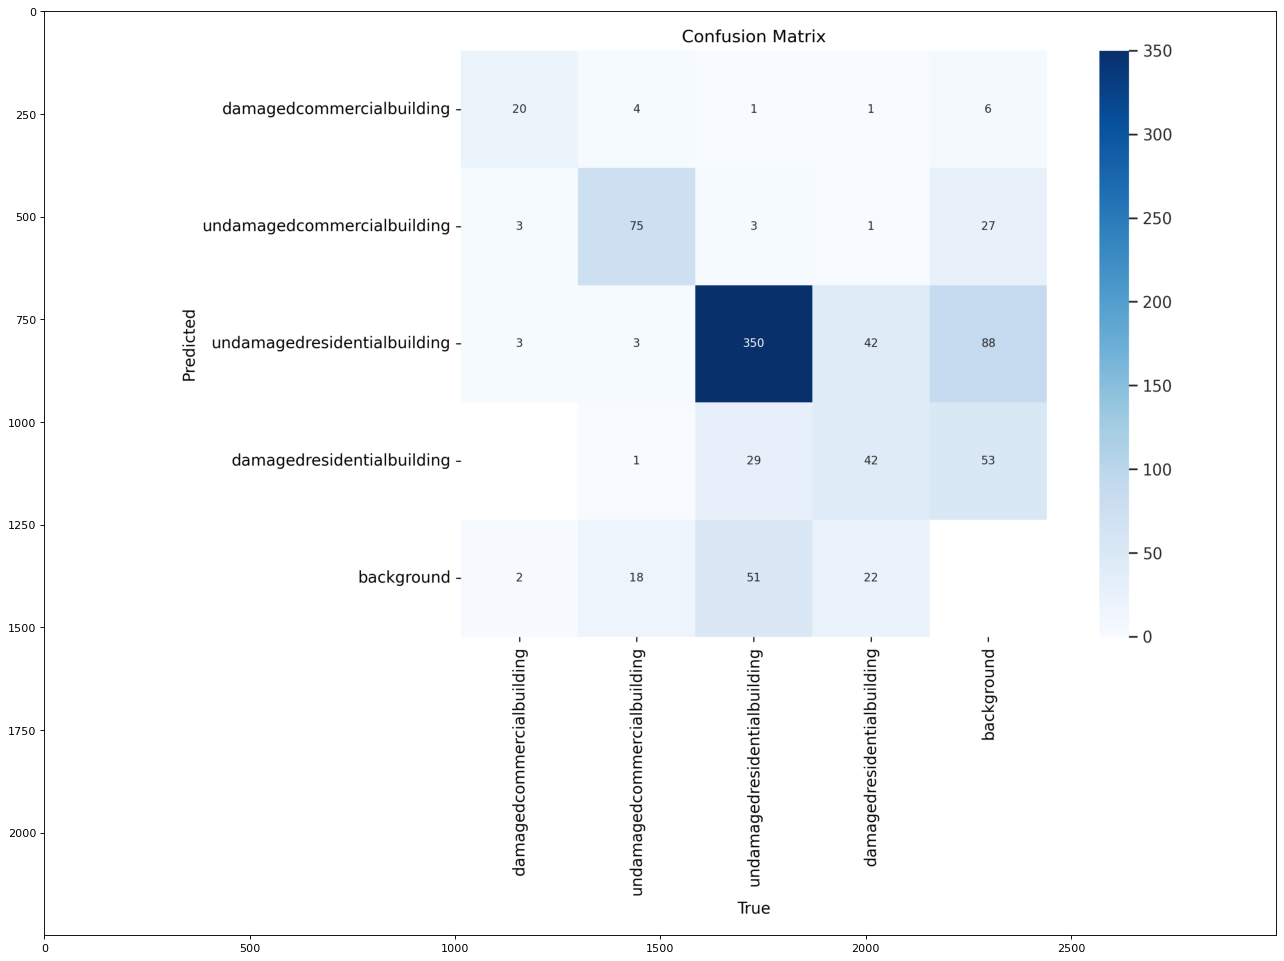

In [15]:
figure(figsize=(20,15), dpi=80)  
# reading the image 
cf = img.imread('runs/detect/train/confusion_matrix.png') 
# displaying the image 
plt.imshow(cf) 

### Making Predictions on the Testing Data

In [16]:
# Load the Model
model = YOLO('./runs/detect/train/weights/best.pt')

In [17]:
# Decoding according to the .yaml file class names order
decoding_of_predictions ={0: 'damagedcommercialbuilding', 1: 'undamagedcommercialbuilding', 2: 'undamagedresidentialbuilding', 3:'damagedresidentialbuilding' }

directory = '/home/jovyan/PlanetaryComputerExamples/datasets/EY_label/challenge_1_submission_images/Submission data'
# Directory to store outputs
results_directory = 'Validation_Data_Results'

# Create submission directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the current object is a file and ends with .jpeg
    if os.path.isfile(os.path.join(directory, filename)) and filename.lower().endswith('.jpg'):
        # Perform operations on the file
        file_path = os.path.join(directory, filename)
        print(file_path)
        print("Making a prediction on ", filename)
        results = model.predict(file_path, save=True, iou=0.5, save_txt=True, conf=0.25)
        
        for r in results:
            conf_list = r.boxes.conf.numpy().tolist()
            clss_list = r.boxes.cls.numpy().tolist()
            original_list = clss_list
            updated_list = []
            for element in original_list:
                 updated_list.append(decoding_of_predictions[int(element)])

        bounding_boxes = r.boxes.xyxy.numpy()
        confidences = conf_list
        class_names = updated_list

        # Check if bounding boxes, confidences and class names match
        if len(bounding_boxes) != len(confidences) or len(bounding_boxes) != len(class_names):
            print("Error: Number of bounding boxes, confidences, and class names should be the same.")
            continue
        text_file_name = os.path.splitext(filename)[0]
        # Creating a new .txt file for each image in the submission_directory
        with open(os.path.join(results_directory, f"{text_file_name}.txt"), "w") as file:
            for i in range(len(bounding_boxes)):
                # Get coordinates of each bounding box
                left, top, right, bottom = bounding_boxes[i]
                # Write content to file in desired format
                file.write(f"{class_names[i]} {confidences[i]} {left} {top} {right} {bottom}\n")
        print("Output files generated successfully.")


/home/jovyan/PlanetaryComputerExamples/datasets/EY_label/challenge_1_submission_images/Submission data/Validation_Post_Event_006.jpg
Making a prediction on  Validation_Post_Event_006.jpg

image 1/1 /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/challenge_1_submission_images/Submission data/Validation_Post_Event_006.jpg: 512x512 1 undamagedcommercialbuilding, 20 undamagedresidentialbuildings, 12 damagedresidentialbuildings, 121.3ms
Speed: 1.4ms preprocess, 121.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels
Output files generated successfully.
/home/jovyan/PlanetaryComputerExamples/datasets/EY_label/challenge_1_submission_images/Submission data/Validation_Post_Event_007.jpg
Making a prediction on  Validation_Post_Event_007.jpg

image 1/1 /home/jovyan/PlanetaryComputerExamples/datasets/EY_label/challenge_1_submission_images/Submission data/Validation_Post_Event_007.jpg: 512x512

An example of a testing picture

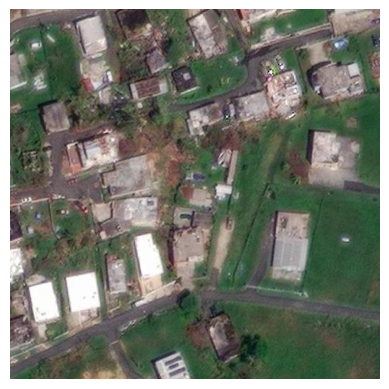

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pred1 = mpimg.imread('Prediction_Data/Validation_Post_Event_001.jpg')
plt.imshow(pred1)
plt.axis('off')
plt.show()

Let us now look at an example of YOLOv8's prediction, to better understanding how this model works.


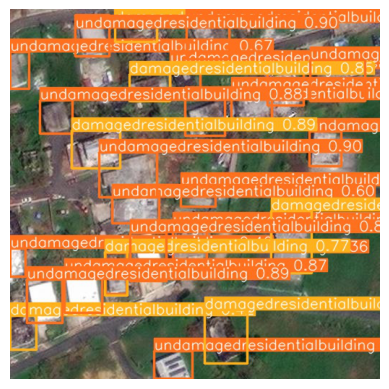

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pred1 = mpimg.imread('runs/detect/predict/Validation_Post_Event_001.jpg')
plt.imshow(pred1)
plt.axis('off')
plt.show()

## Conclusion

<div align ="justify">In summary, this notebook is divided into the following steps:
<ul>
    <li>Download and process satellite images data (donwload, create tiles, convert to .jpg, annotate using LabelMe</li>
    <li>Divide the processed data into training and testing, you can check more information at <a href = "https://github.com/rooneysh/Labelme2YOLO/"><b>Labelme2YOLO.</b></a></li>
    <li>Train the model, pay attention to data source in the yaml file</li>
    <li>Use the trained model on tha unseen data and check the results to see how the model works</li>
</ul>
</div>

**This model has landed in the top 3% among over 1,800 participants in EY Data Science Challenge 2024**